<a href="https://colab.research.google.com/github/NgHenri/france-geojson/blob/master/Projet7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Standard Libraries
import os
import sys
import warnings
from datetime import datetime
from time import time
import unicodedata

# Data Manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from os import listdir
from joblib import dump
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc

# Détermine si vous êtes sur Google Colab
is_colab = 'google.colab' in sys.modules

# Détermine si vous êtes sur Kaggle
is_kaggle = '/kaggle' in os.getcwd()

# Chemin par défaut
path = None

if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/Python/OCRP/Projet07/data/credit-default-risk'
    output_dir = '/content/drive/MyDrive/Python/OCRP/Projet07/working/graphs'
    os.makedirs(output_dir, exist_ok=True)
    print("\nTu es sur Google Colab")
elif is_kaggle:
    path = "/kaggle/input/credit-risk"
    output_dir = '/kaggle/working/graphs'
    os.makedirs(output_dir, exist_ok=True)
    print("\nTu es sur Kaggle")
else:
    path = "~/Documents/Python/OCR/Projet07/data/credit-risk"
    output_dir = "~/Documents/Python/OCR/Projet07/working/graphs"
    os.makedirs(output_dir, exist_ok=True)
    print("\nTu es en local")

# Utilisez le chemin d'accès sélectionné pour accéder à vos données
if path is not None:
    print("Chemin d'accès aux données:", path)
else:
    print("Impossible de déterminer l'environnement.")
# Chemin d'accès aux données
save_path = "/content/drive/MyDrive/Python/OCRP/Projet07/working/ouput_data"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Tu es sur Google Colab
Chemin d'accès aux données: /content/drive/MyDrive/Python/OCRP/Projet07/data/credit-default-risk


In [5]:
pd.set_option('display.max_columns', None)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 200)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

In [ ]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


In [ ]:
%cd /content/drive/MyDrive/Python/OCRP/Projet07/working/ouput_data/

/content/drive/MyDrive/Python/OCRP/Projet07/working/ouput_data


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Current working directory: /content/drive/MyDrive/Python/OCRP/Projet07/working/ouput_data_test
Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 2s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Process POS-CASH balance - done in 1s
Installments payments df shape: (8893, 26)
Process installments payments - done in 1s
Credit card balance df shape: (9520, 131)
Process credit card balance - done in 1s
Combined data saved to 'combined_data.csv'
Unique values in target column: [1. 0.]
Starting LightGBM. Train shape: (10000, 768), test shape: (10000, 768)
Fold  1 AUC : 0.765036
Fold  2 AUC : 0.817679
Fold  3 AUC : 0.756285
Fold  4 AUC : 0.782578
Fold  5 AUC : 0.798197
Fold  6 AUC : 0.775900
Fold  7 AUC : 0.756436
Fold  8 AUC : 0.719273
Fold  9 AUC : 0.731037
Fold 10 AUC : 0.727922
Full AUC score 0.759825
LightGBM models trained.
Feature importances sa

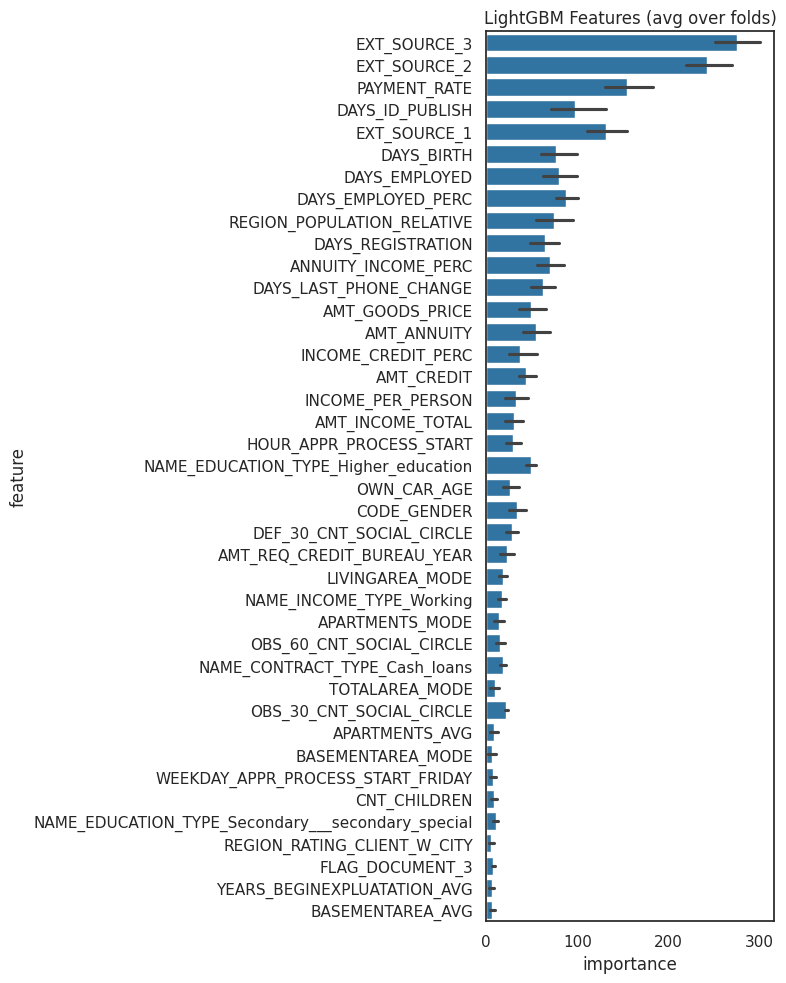

In [ ]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables.
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import pandas as pd
import gc
from sklearn.impute import SimpleImputer
import os
from joblib import dump
from joblib import load
import pickle

# Fonction pour mesurer le temps d'exécution
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# Define the path variable
path = '/content/drive/MyDrive/Python/OCRP/Projet07/data/credit-default-risk'

def make_dir(folder):
    """
    Créez le dossier s'il n'existe pas déjà
    """
    if not os.path.exists(folder):
        os.makedirs(folder)

# Fonction pour enregistrer le fichier de soumission
def save_submission(submission, submission_file_name):
    """
    Enregistre la soumission dans un fichier CSV
    """
    submission.to_csv(submission_file_name, index=False)
    print(f"File saved as {submission_file_name}")

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(f'{path}/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(f'{path}/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
   # print(f"Type of df: {type(df)}")
   # print(f"Type of test_df: {type(test_df)}")
    #df = df.append(test_df).reset_index()
    df = pd.concat([df,test_df]).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(f'{path}/bureau.csv', nrows = num_rows)
    bb = pd.read_csv(f'{path}/bureau_balance.csv', nrows = num_rows)
   # print(f"Type of bb: {type(bb)}")
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)

    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
   # print(f"Type of bureau: {type(bureau)}")


    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(f'{path}/previous_application.csv', nrows = num_rows)
   # print(f"Type of prev: {type(prev)}")
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(f'{path}/POS_CASH_balance.csv', nrows = num_rows)
   # print(f"Type of pos before encoding: {type(pos)}")
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
   # print(f"Type of pos after encoding: {type(pos)}")
   # print(f"Type of cat_cols: {type(cat_cols)}")

    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(f'{path}/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(f'{path}/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified=False, debug=False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]

    # Nettoyer les noms de colonnes
    def clean_column_names(df):
        df.columns = [re.sub(r'[^\w]', '_', col) for col in df.columns]
        return df

    train_df = clean_column_names(train_df)
    test_df = clean_column_names(test_df)

    print("Unique values in target column:", train_df['TARGET'].unique())

    # Assurez-vous de travailler avec des copies explicites si nécessaire
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Convertir toutes les colonnes de type 'object' en 'float' ou 'int'
    for col in train_df.columns:
        if train_df[col].dtype == 'object':
            train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
            test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    models = []

    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbosity=-1,
            early_stopping_rounds=200
        )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

        # Stocker le modèle pour chaque fold
        models.append(clf)

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    # Enregistrement des importances dans différents formats
    feature_importance_df.to_pickle('feature_importance.pkl')
    feature_importance_df.to_csv('feature_importance.csv', index=False)

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index=False)

    display_importances(feature_importance_df)

        # Sauvegarder le modèle final au format .pkl
    with open('lightgbm_model.pkl', 'wb') as f:
        pickle.dump(models[-1], f)  # Sauvegarder le dernier modèle entraîné

    # Retourner le modèle final et les importances des caractéristiques
    return feature_importance_df, models[-1]  # Retourner le dernier modèle entraîné


# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False),palette="plasma")
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug = True):
    num_rows = 10000 if debug else None

    # Créer le répertoire de travail s'il n'existe pas déjà
    working_directory = "/content/drive/MyDrive/Python/OCRP/Projet07/working/ouput_data_test"
    make_dir(working_directory)
    # Changer de répertoire de travail
    os.chdir(working_directory)
    print(f"Current working directory: {os.getcwd()}")
    # Chargement des données
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    # Sauvegarder le DataFrame combiné
    df.to_csv('combined_data.csv', index=False)
    print("Combined data saved to 'combined_data.csv'")

    # Run LightGBM with kfold
    with timer("Run LightGBM with kfold"):
        feat_importance, model = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)
        print("LightGBM models trained.")

        # Sauvegarde des importances des caractéristiques
        feat_importance.to_csv('feature_importances_f.csv', index=False)
        print("Feature importances saved.")

        # Sauvegarde du modèle LightGBM
        dump(model, 'lightgbm_model.joblib')
        print("LightGBM model saved.")

if __name__ == "__main__":
    submission_file_name = "submission_kernel_t.csv"
    with timer("Full model run"):
        main()

In [ ]:
data = pd.read_csv('combined_data.csv')
data.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning

Starting main()
Current working directory: /content
Train samples: 10000, test samples: 10000
Bureau df shape: (2011, 108)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (9734, 242)
Process previous_applications - done in 1s
Pos-cash balance df shape: (9494, 15)
Process POS-CASH balance - done in 1s
Installments payments df shape: (8893, 26)
Process installments payments - done in 0s
Credit card balance df shape: (9520, 131)
Process credit card balance - done in 0s
Combined data save to : combined_data_2024-08-04_10-08-49.csv
Train DataFrame shape: (10000, 768)
Test DataFrame shape: (10000, 768)
Unique values in target column: [1. 0.]
Starting LightGBM. Train shape: (10000, 768), test shape: (10000, 768)
Fold  1 AUC : 0.762181
Fold  2 AUC : 0.779882
Fold  3 AUC : 0.767562
Fold  4 AUC : 0.748387
Fold  5 AUC : 0.758663
Fold  6 AUC : 0.758242
Fold  7 AUC : 0.766332
Fold  8 AUC : 0.768077
Fold  9 AUC : 0.745860
Fold 10 AUC : 0.750855
Full AUC score 0.759578


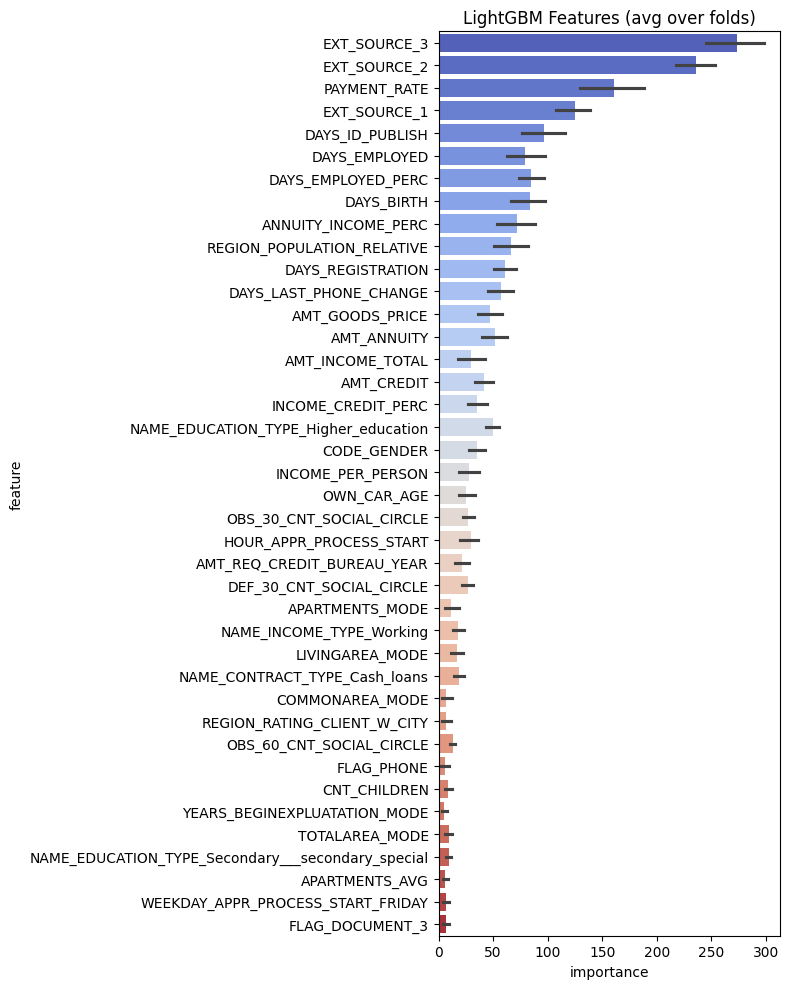

In [2]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables.
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)
import os
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
import re
from datetime import datetime
import pickle
from joblib import dump, load
from pathlib import Path


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# Define the path variable
path = '/content/drive/MyDrive/Python/OCRP/Projet07/data/credit-default-risk'

def make_dir(folder):
    """
    Créez le dossier s'il n'existe pas déjà
    """
    if not os.path.exists(folder):
        os.makedirs(folder)

# Fonction pour enregistrer le fichier de soumission
def save_submission(submission, submission_file_name):
    """
    Enregistre la soumission dans un fichier CSV
    """
    submission.to_csv(submission_file_name, index=False)
    print(f"File saved as {submission_file_name}")
    return submission_file_name

def get_timestamped_filename(base_name, extension):
    now = datetime.now()
    timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"{base_name}_{timestamp}.{extension}"
    return filename

# Fonction pour créer et changer de répertoire de travail
def create_and_change_working_directory(base_directory):
    # Générer un nom de répertoire unique basé sur la date et l'heure
    timestamp = datetime.now().strftime("%d-%m_%H-%M-%S")
    working_directory = os.path.join(base_directory, f"output_{timestamp}")

    # Créer le répertoire s'il n'existe pas déjà
    make_dir(working_directory)

    # Changer le répertoire courant pour le nouveau répertoire de travail
    os.chdir(working_directory)

    return working_directory


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv(f'{path}/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv(f'{path}/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))

    df = pd.concat([df,test_df]).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv(f'{path}/bureau.csv', nrows = num_rows)
    bb = pd.read_csv(f'{path}/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)

    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)


    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv(f'{path}/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv(f'{path}/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)


    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv(f'{path}/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv(f'{path}/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):

    working_directory = os.getcwd()

    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]

    print("Train DataFrame shape:", train_df.shape)
    print("Test DataFrame shape:", test_df.shape)

    # Nettoyer les noms de colonnes
    def clean_column_names(df):
        df.columns = [re.sub(r'[^\w]', '_', col) for col in df.columns]
        return df

    def impute_missing_values(df):
        imputer_num = SimpleImputer(strategy='mean')
        imputer_cat = SimpleImputer(strategy='most_frequent')

        # Séparer les colonnes numériques et catégorielles
        num_cols = df.select_dtypes(include=[np.number]).columns
        cat_cols = df.select_dtypes(exclude=[np.number]).columns

        # Imputer les valeurs manquantes
        df[num_cols] = imputer_num.fit_transform(df[num_cols])
        df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])

        return df

    train_df = clean_column_names(train_df)
    test_df = clean_column_names(test_df)

    #print("Train columns:", train_df.columns)
    #print("Test columns:", test_df.columns)

    print("Unique values in target column:", train_df['TARGET'].unique())

    # Convertir toutes les colonnes de type 'object' en 'float' ou 'int'
    for col in train_df.select_dtypes(include=['object']).columns:
        train_df[col] = pd.to_numeric(train_df[col], errors='coerce')
        test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    models = []

    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbosity=-1,
            early_stopping_rounds= 200
        )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_metric= 'auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))

        models.append(clf)

        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

    # Nommer le fichier de soumission
    submission_file = get_timestamped_filename('submission_file', 'csv')

    filepath = Path('/content/drive/MyDrive/Python/OCRP/Projet07/working/submision')

    make_dir(filepath)
    # Chemin complet du fichier de soumission
    submission_filepath = filepath / submission_file

    # Enregistrer les prédictions
    print("Save Submission file name:", submission_file)
    # Write submission file and plot feature importance
    #if not debug:
    if  debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_filepath, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df, models[-1]

# Display/plot feature importance
def display_importances(feature_importance_df_):
    lgbm_importances_png = get_timestamped_filename('lgbm_importances', 'png')
    filepath = Path('/content/drive/MyDrive/Python/OCRP/Projet07/working/graphs')
    make_dir(filepath)
    # Chemin complet du fichier des plots png
    lgbm_importances_path = filepath / lgbm_importances_png

    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False),palette="coolwarm")
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(lgbm_importances_path)


def main(debug = True):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    # Sauvegarder le DataFrame combiné
    filepath = Path('/content/drive/MyDrive/Python/OCRP/Projet07/working/data')
    make_dir(filepath)
    combined_data_file = get_timestamped_filename('combined_data', 'csv')
    # Chemin complet du fichier de soumission
    combined_data_path = filepath / combined_data_file

    print("Combined data save to :", combined_data_file)
    df.to_csv(combined_data_path, index=False)

    with timer("Run LightGBM with kfold"):
        feat_importance, clf = kfold_lightgbm(df, num_folds= 10, stratified= True, debug= debug)

    with timer("Change drectory"):
        # Créer le répertoire de travail s'il n'existe pas déjà
        base_directory = "/content/drive/MyDrive/Python/OCRP/Projet07/working"
        working_directory = create_and_change_working_directory(base_directory)
        print("Current working directory:", os.getcwd())

        # Changer le répertoire de travail
        #os.chdir(working_directory)
        #print("Current working directory:", os.getcwd())

        # Sauvegarder les importances des caractéristiques
        feature_importance_file = get_timestamped_filename('feature_importance', 'csv')
        feat_importance.to_csv(feature_importance_file, index=False)
        print("Feature importance saved to:", feature_importance_file)

        # Sauvegarder le modèle LGBM
        model_file_pkl = get_timestamped_filename('lightgbm_model', 'pkl')
        model_file_joblib = get_timestamped_filename('lightgbm_model', 'joblib')
        with open(os.path.join(working_directory, model_file_pkl), 'wb') as f:
            pickle.dump(clf, f)
        print("LightGBM model saved to:", model_file_pkl)

        # Sauvegarder le modèle LightGBM
        dump(clf, os.path.join(working_directory, model_file_joblib))
        print("LightGBM model saved to:", model_file_joblib)

    return feat_importance , clf , df

# Appeler main() et capturer les résultats
if __name__ == "__main__":
    print("Starting main()")
    print("Current working directory:", os.getcwd())
    with timer("Full model run"):
        feat_importance, clf, df = main()
    print("Main function completed.")

In [4]:
feat_importance.head()

,feature,importance,fold
0,CODE_GENDER,47,1
1,FLAG_OWN_CAR,1,1
2,FLAG_OWN_REALTY,4,1
3,CNT_CHILDREN,10,1
4,AMT_INCOME_TOTAL,70,1
...,...,...,...
760,CC_NAME_CONTRACT_STATUS_nan_MAX,0,10
761,CC_NAME_CONTRACT_STATUS_nan_MEAN,0,10
762,CC_NAME_CONTRACT_STATUS_nan_SUM,0,10
763,CC_NAME_CONTRACT_STATUS_nan_VAR,0,10


In [ ]:
def calc_rank_feature(df: pd.DataFrame, modelname='model') -> pd.DataFrame:
    ret = df.groupby(['feature'])['importance'].mean(
    ).sort_values(ascending=False).reset_index()
    ret = ret.rename_axis('rank').reset_index()
    ret['rank'] = ret['rank'].astype(int)
    ret['model'] = modelname
    return ret

import os
import pandas as pd

def load_latest_file(directory, prefix=''):
    # Liste tous les fichiers dans le répertoire
    files = os.listdir(directory)

    # Filtrer les fichiers par préfixe ou motif spécifique (optionnel)
    files = [f for f in files if f.startswith(prefix) and f.endswith('.csv')]  # Exemple pour les fichiers CSV

    # Trier les fichiers par date de modification (du plus récent au plus ancien)
    files.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)), reverse=True)

    # Sélectionner le premier fichier (le plus récent)
    latest_file = files[0] if files else None

    if latest_file:
        # Charger le fichier CSV dans un DataFrame pandas
        file_path = os.path.join(directory, latest_file)
        df = pd.read_csv(file_path)
        return df
    else:
        print(f"Aucun fichier trouvé dans le répertoire {directory} avec le préfixe {prefix}.")
        return None


# Exemple d'utilisation
directory = '/content/drive/MyDrive/Python/OCRP/Projet07/working/ouput'
prefix = 'feature_importance_'  # Préfixe des fichiers à rechercher

feat_importance_lgbm = load_latest_file(directory, prefix)
if feat_importance_lgbm is not None:
    lgbm = calc_rank_feature(feat_importance_lgbm, 'lgbm')
lgbm.head()

,rank,feature,importance,model
0,0,EXT_SOURCE_3,273.20,lgbm
1,1,EXT_SOURCE_2,236.00,lgbm
2,2,PAYMENT_RATE,161.20,lgbm
3,3,EXT_SOURCE_1,125.50,lgbm
4,4,DAYS_ID_PUBLISH,96.40,lgbm


In [ ]:
import os
print(os.getcwd())

/content/drive/MyDrive/Python/OCRP/Projet07/working/ouput_data_test


In [ ]:
import pandas as pd

# Charger les données originales et les prédictions
path = '/content/drive/MyDrive/Python/OCRP/Projet07/data/credit-default-risk'

test_df = pd.read_csv(os.path.join(path, 'application_test.csv'))
submission_df = pd.read_csv('/content/drive/MyDrive/Github/submission_kernel02.csv')

# Fusionner les deux DataFrames sur 'SK_ID_CURR'
merged_df = test_df.merge(submission_df, on='SK_ID_CURR', how='left')

# Afficher les premières lignes pour voir les informations des clients avec leurs prédictions
merged_df.head()


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.035649
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.148850
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,0.027979
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,0.038590
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.152339


In [ ]:
import sys

# Afficher la taille du jeu de données en mémoire
print("La taille du jeu de données est de {:.2f} MB".format(sys.getsizeof(submission_df) / (1024*1024)))
submission_df.shape #(356251, 773)


La taille du jeu de données est de 0.74 MB


(48744, 2)

In [ ]:
# Trier les clients par la probabilité de défaut en ordre décroissant
high_risk_clients = merged_df.sort_values(by='TARGET', ascending=False)

# Afficher les premières lignes pour voir les clients les plus à risque avec leurs caractéristiques
high_risk_clients.head(10)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
12216,188739,Cash loans,M,N,Y,0,135000.0,300960.0,21897.0,225000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.748124
38552,383433,Cash loans,F,N,Y,1,157500.0,291915.0,23193.0,252000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.741886
4525,132358,Cash loans,F,N,N,0,130500.0,407520.0,32197.5,360000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.739602
22815,265895,Cash loans,M,N,N,0,121500.0,450000.0,24412.5,450000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.738386
2838,119896,Cash loans,M,Y,Y,1,189000.0,630000.0,32296.5,630000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.734229
2035,114283,Cash loans,M,N,N,0,90000.0,156384.0,14341.5,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0,0.730445
11587,184226,Cash loans,F,N,N,0,157500.0,440784.0,34956.0,360000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.719884
7129,152140,Cash loans,M,N,Y,0,360000.0,239418.0,17419.5,211500.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.710161
9647,170148,Cash loans,M,N,Y,0,90000.0,265500.0,21105.0,265500.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0.709620
13083,195050,Cash loans,M,Y,Y,0,157500.0,601470.0,30838.5,450000.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,0.704391


In [ ]:
# Par exemple, voir les clients avec une probabilité de défaut supérieure à 0.5
risky_clients = merged_df[merged_df['TARGET'] > 0.5]

# Afficher quelques caractéristiques de ces clients
risky_clients[['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DAYS_BIRTH', 'TARGET']].head()


,SK_ID_CURR,AMT_INCOME_TOTAL,AMT_CREDIT,DAYS_BIRTH,TARGET
37,100278,121500.0,450000.0,-10834,0.510126
129,101008,135000.0,497520.0,-13119,0.508387
634,104410,157500.0,435276.0,-15740,0.564703
1140,108045,112500.0,278505.0,-15002,0.501214
1610,111452,333000.0,748651.5,-14540,0.558078


In [ ]:
!pip install lightgbm

In [4]:
!pip install dask[dataframe]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 1.9 MB/s eta 0:00:00
